In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных

In [3]:
df = pd.read_excel('Когортный анализ.xlsx')
print(df.shape)
df.head()

(704840, 3)


,user_id,date,price
0,A0005,2020-03-25,50
1,A0005,2020-03-25,40
2,A0005,2020-03-26,70
3,A0005,2020-03-27,20
4,A0005,2020-03-29,50


In [4]:
df.isna().sum()

,0
user_id,0
date,0
price,0


In [5]:
df.dtypes

,0
user_id,object
date,datetime64[ns]
price,int64


In [6]:
# даты первых и последних покупок каждого пользователя

user_first_buy_date = df.groupby('user_id')['date'].agg('min').reset_index()
user_first_buy_date = user_first_buy_date.rename({'date': 'user_first_buy_date'}, axis=1)

user_last_buy_date = df.groupby('user_id')['date'].agg('max').reset_index()
user_last_buy_date = user_last_buy_date.rename({'date': 'user_last_buy_date'}, axis=1)

df['user_first_buy_date'] = df['user_id'].map(user_first_buy_date.set_index('user_id')['user_first_buy_date'])
df['user_last_buy_date'] = df['user_id'].map(user_last_buy_date.set_index('user_id')['user_last_buy_date'])
df.head()

,user_id,date,price,user_first_buy_date,user_last_buy_date
0,A0005,2020-03-25,50,2020-03-25,2020-04-05
1,A0005,2020-03-25,40,2020-03-25,2020-04-05
2,A0005,2020-03-26,70,2020-03-25,2020-04-05
3,A0005,2020-03-27,20,2020-03-25,2020-04-05
4,A0005,2020-03-29,50,2020-03-25,2020-04-05


In [7]:
def first_day_month_yaer(date):
  return pd.Timestamp(year=date.year, month=date.month, day=1)

df['month_year'] = df['date'].apply(first_day_month_yaer) # месяц и год покупки
df['user_first_buy_month_year'] = df['user_first_buy_date'].apply(first_day_month_yaer) # месяц и год первой покупки
df['user_last_buy_month_year'] = df['user_last_buy_date'].apply(first_day_month_yaer) # месяц и год последней покупки
df.head()

,user_id,date,price,user_first_buy_date,user_last_buy_date,month_year,user_first_buy_month_year,user_last_buy_month_year
0,A0005,2020-03-25,50,2020-03-25,2020-04-05,2020-03-01,2020-03-01,2020-04-01
1,A0005,2020-03-25,40,2020-03-25,2020-04-05,2020-03-01,2020-03-01,2020-04-01
2,A0005,2020-03-26,70,2020-03-25,2020-04-05,2020-03-01,2020-03-01,2020-04-01
3,A0005,2020-03-27,20,2020-03-25,2020-04-05,2020-03-01,2020-03-01,2020-04-01
4,A0005,2020-03-29,50,2020-03-25,2020-04-05,2020-03-01,2020-03-01,2020-04-01


In [8]:
# первый день месца начала измерений
start_month_year = first_day_month_yaer(df['month_year'].min())

# первый день месца конца измерений
end_month_year = first_day_month_yaer(df['month_year'].max())

start_month_year, end_month_year

(Timestamp('2020-01-01 00:00:00'), Timestamp('2021-02-01 00:00:00'))

In [9]:
drop_last_month = True

if drop_last_month:
  # исключить данные о месяце мосдедней покупки (т.к. они не полные)
  df = df.loc[df.user_last_buy_month_year != df.month_year]

In [10]:
def month_betwen_dates(date1, date2):
  return (date1.year - date2.year) * 12 + date1.month - date2.month

In [11]:
# кол-во дней с первой покупки
df['month_since_first_buy_for_user'] = (
    month_betwen_dates(df.month_year.dt, df.user_first_buy_month_year.dt) + 1
)
df['month_since_first_buy_for_user'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int32)

In [12]:
# month_year_to_month_number = {
#     start_month_year + pd.DateOffset(months=i%12, years=i//12): i+1 for i in range(month_total+1)
# }

# month_year_to_month_number

In [13]:
# list(enumerate(sorted(df['month_year'].unique())))

In [14]:
# сводная таблица (когортный анализ) по количеству покупок в разрезе месяца
# первой покупки и кол-ва месяцев, прошедших с первой покупки
count_pivot = df.pivot_table(columns='month_since_first_buy_for_user', index='user_first_buy_month_year', values='user_id', aggfunc=len)
count_pivot.index = count_pivot.index.strftime('%m.%Y')
count_pivot.index.rename('first_buy_month_year', inplace=True)
count_pivot.columns.rename('month_since_first_buy', inplace=True)
count_pivot

month_since_first_buy,1,2,3,4,5,6,7,8,9,10,11,12,13
first_buy_month_year,,,,,,,,,,,,,
01.2020,5565.0,6987.0,6924.0,6545.0,5364.0,4786.0,4339.0,4133.0,4061.0,4145.0,3714.0,3703.0,3539.0
02.2020,4727.0,6483.0,5418.0,5493.0,4274.0,3648.0,3095.0,2718.0,2240.0,2112.0,1648.0,1473.0,NaN
03.2020,7058.0,8310.0,7987.0,7732.0,6671.0,5594.0,5305.0,4681.0,4521.0,4532.0,4311.0,NaN,NaN
04.2020,5362.0,6815.0,5910.0,5986.0,4889.0,3530.0,3527.0,3197.0,3219.0,2964.0,NaN,NaN,NaN
05.2020,7726.0,8940.0,8355.0,8247.0,6969.0,6186.0,5768.0,5548.0,5372.0,NaN,NaN,NaN,NaN
06.2020,5851.0,7607.0,6576.0,6490.0,5710.0,4721.0,4432.0,3920.0,NaN,NaN,NaN,NaN,NaN
07.2020,8189.0,9165.0,8166.0,7959.0,6578.0,6457.0,5991.0,NaN,NaN,NaN,NaN,NaN,NaN
08.2020,6559.0,7748.0,6949.0,7015.0,6191.0,5265.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09.2020,8561.0,9227.0,8641.0,8496.0,7185.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# сводная таблица (когортный анализ) по метрике retention в разрезе месяца
# первой покупки и кол-ва месяцев, прошедших с первой покупки
retention_pivot = (count_pivot.T / count_pivot[1].T).T
retention_pivot

month_since_first_buy,1,2,3,4,5,6,7,8,9,10,11,12,13
first_buy_month_year,,,,,,,,,,,,,
01.2020,1.0,1.255526,1.244205,1.176101,0.963881,0.860018,0.779695,0.742677,0.729739,0.744834,0.667385,0.665409,0.635939
02.2020,1.0,1.371483,1.146182,1.162048,0.904168,0.771737,0.654749,0.574995,0.473873,0.446795,0.348635,0.311614,NaN
03.2020,1.0,1.177387,1.131624,1.095494,0.945169,0.792576,0.751629,0.663219,0.640550,0.642108,0.610796,NaN,NaN
04.2020,1.0,1.270981,1.102201,1.116374,0.911787,0.658336,0.657777,0.596233,0.600336,0.552779,NaN,NaN,NaN
05.2020,1.0,1.157132,1.081413,1.067435,0.902019,0.800673,0.746570,0.718095,0.695315,NaN,NaN,NaN,NaN
06.2020,1.0,1.300120,1.123910,1.109212,0.975902,0.806871,0.757477,0.669971,NaN,NaN,NaN,NaN,NaN
07.2020,1.0,1.119184,0.997191,0.971914,0.803273,0.788497,0.731591,NaN,NaN,NaN,NaN,NaN,NaN
08.2020,1.0,1.181278,1.059460,1.069523,0.943894,0.802714,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09.2020,1.0,1.077795,1.009345,0.992407,0.839271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


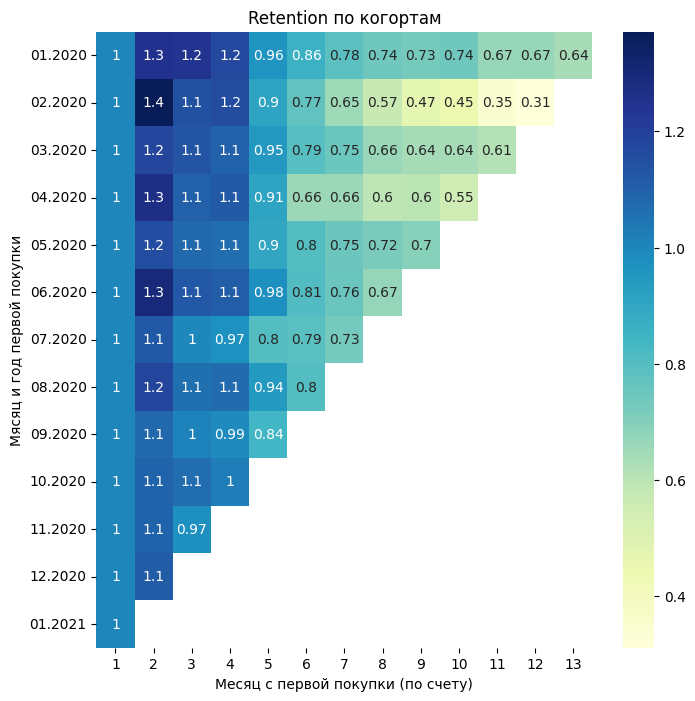

In [37]:
# Визуализация сводной таблицы по метрике retention в разрезе месяца
# первой и кол-ва месяцев, прошедших с первой покупки
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(retention_pivot, annot=True, cmap='YlGnBu', ax=ax)
plt.title('Retention по когортам')
plt.yticks(rotation=0)
ax.set_xlabel('Месяц с первой покупки (по счету)')
ax.set_ylabel('Мясяц и год первой покупки');

In [33]:
# таблица процентов снижения retention по сравнению с предыдущем месяцем

count_pivot_bias = count_pivot.iloc[:,1:]
count_pivot_bias.columns = count_pivot_bias.columns-1

count_pivot_shorter = count_pivot.iloc[:,:-1]

retention_decrease = 100 * (count_pivot_shorter - count_pivot_bias) / count_pivot_shorter
retention_decrease.columns += 1
retention_decrease

month_since_first_buy,2,3,4,5,6,7,8,9,10,11,12,13
first_buy_month_year,,,,,,,,,,,,
01.2020,-25.552561,0.901675,5.473715,18.044309,10.775541,9.339741,4.747638,1.742076,-2.068456,10.398070,0.296177,4.428841
02.2020,-37.148297,16.427580,-1.384275,22.191881,14.646701,15.158991,12.180937,17.586461,5.714286,21.969697,10.618932,NaN
03.2020,-17.738736,3.886883,3.192688,13.722193,16.144506,5.166250,11.762488,3.418073,-0.243309,4.876434,NaN,NaN
04.2020,-27.098098,13.279530,-1.285956,18.326094,27.797096,0.084986,9.356394,-0.688145,7.921715,NaN,NaN,NaN
05.2020,-15.713176,6.543624,1.292639,15.496544,11.235471,6.757194,3.814147,3.172314,NaN,NaN,NaN,NaN
06.2020,-30.011964,13.553306,1.307786,12.018490,17.320490,6.121584,11.552347,NaN,NaN,NaN,NaN,NaN
07.2020,-11.918427,10.900164,2.534901,17.351426,1.839465,7.216974,NaN,NaN,NaN,NaN,NaN,NaN
08.2020,-18.127763,10.312339,-0.949777,11.746258,14.957196,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09.2020,-7.779465,6.350927,1.678047,15.430791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


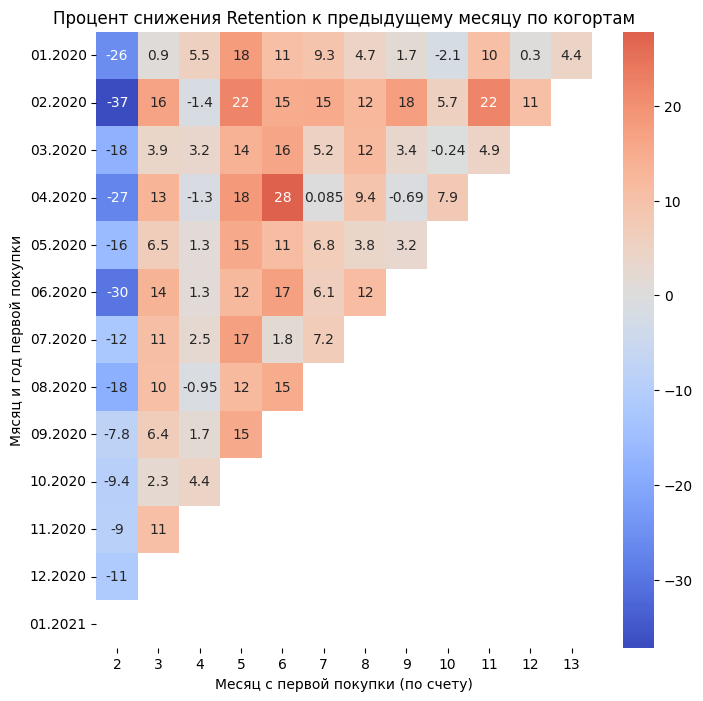

In [36]:
# визуализация процентов снижения retention по сравнению с предыдущем месяцем
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(retention_decrease, annot=True, cmap='coolwarm', ax=ax, center=0);
plt.title('Процент снижения Retention к предыдущему месяцу по когортам')
plt.yticks(rotation=0)
ax.set_xlabel('Месяц с первой покупки (по счету)')
ax.set_ylabel('Мясяц и год первой покупки');